<a href="https://colab.research.google.com/github/boskidisanalysis/Stories-And-Images/blob/main/Stories_and_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
!pip install --upgrade diffusers transformers ftfy scipy #codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 30.5 MB/s 
     |████████████████████████████████| 4.9 MB 56.0 MB/s 
     |████████████████████████████████| 53 kB 969 kB/s 
     |████████████████████████████████| 163 kB 66.1 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import matplotlib.pyplot as plt

In [ ]:
filepath= '/content/drive/MyDrive/AI_photos/Scarecrow_and_Castles'
import os
if not os.path.exists(filepath):
   os.makedirs(filepath)

# Models

In [ ]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Use the K-LMS scheduler here instead
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               #revision="fp16", 
                                               #torch_dtype=torch.float16,
                                               scheduler=scheduler,
                                               use_auth_token=True)
pipe = pipe.to(device)
pipe.enable_attention_slicing() #cost of 10% in speed but uses less gpu memory

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline, set_seed
story_pipe = pipeline('text-generation', model='distilgpt2')

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
story_models = ['bigscience/T0_3B','gpt2', 'gpt2-medium','distilgpt2','bigscience/bloom-560m']

In [ ]:
from transformers import pipeline, set_seed
story_pipe = pipeline('text-generation', model=story_models[1])

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
prompt_models = ['succinctly/text2image-prompt-generator','Gustavosta/MagicPrompt-Stable-Diffusion','bartman081523/stable-diffusion-prompt-generator-gpt2']

In [ ]:
from transformers import pipeline, set_seed
prompt_pipe = pipeline('text-generation', model=prompt_models[1])

Downloading:   0%|          | 0.00/912 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
from datetime import datetime

date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

#Functions 

In [ ]:
def make_prompt(initial_prompt,max_length=60,number_of_images=2):
    
    prompt = prompt_pipe(initial_prompt,max_length=max_length, num_return_sequences=number_of_images)
    generated_prompt = [text['generated_text'] for text in prompt]
    return generated_prompt

In [ ]:
def make_story(initial_prompt,max_length=60,number_of_stories=5,**kwargs):
    
    prompt = story_pipe(initial_prompt, max_length=max_length, num_return_sequences=number_of_stories)
    generated_prompt = [text['generated_text'] for text in prompt]
    return generated_prompt

In [ ]:
def save_images(images, filepath,prompt):
    for num, image in enumerate(images):
        topnames= prompt[num].split()[:10]
        savenames = ' '.join(topnames)
        date = datetime.now().strftime(" %Y_%m_%d-%I_%M_%S")
        image.save(f'{filepath + savenames +date} {num}.png')

def metadata_plot(images, filepath, prompt,initial_prompt):
    #with plt.xkcd():
    fig, axs = plt.subplots(len(images),figsize=(12, 12))
    axs = axs.flatten()
    fig.patch.set_facecolor('white')
    for img, ax, txt in zip(images, axs,prompt):
        ax.imshow(img,aspect='equal')
        ax.set_axis_off()
        toptext= txt.split()[:8]
        savename = ' '.join(toptext)
        ax.set_title(txt,wrap=True)
  #         fig.suptitle(f'Total emissions from the generated images: {round(co2_emissions*1000,3)} g of CO2',
  #                      weight='bold')
      #plt.show();
    #plt.tight_layout()
    fig.suptitle(initial_prompt)
    fig
    date = datetime.now().strftime(" %Y_%m_%d-%I_%M_%S")
    topnames= initial_prompt.split()[:10]
    savenames = ' '.join(topnames)
    plt.savefig(f'{filepath + savenames+ date} metadata.png')

#from codecarbon import track_emissions
#  decorator(@) track_emissions
def make_and_save_images(prompt,initial_prompt,filepath,guidance_scale=7.5,num_inference_steps=50,*args,**kwargs):
    '''
    **kwargs: 
              guidance_scale:
              num_inference_steps: 
    '''

#     from codecarbon import EmissionsTracker
#     tracker = EmissionsTracker()
#     tracker.start()
    with autocast('cuda'):
        images = pipe(prompt,guidance_scale=guidance_scale,num_inference_steps=num_inference_steps).images
#     co2_emissions = tracker.stop()
#     tracker.stop()
    metadata_plot(images,filepath,prompt,initial_prompt,)
    save_images(images,filepath,prompt)

In [ ]:
def make_images(initial_prompt,filepath,random_prompts=True,num_images=4,*args,**kwargs):
  '''
  Create and Saves images to a filepath from an initial prompt.  

  initial_prompt: (str) your prompt to genarate images from
  filepath: (str) the filepath in which the images will be saved
  random_prompts: (bool) if True uses a model to enhance the prompt, 
                  if False uses only the prompt provided
  num_images: (int) The number of images to be created
  
  **kwargs: 
  max_length= int, default 50
  guidance_scale: default 7.5
  num_inference_steps: default 50
  
  '''
  if not random_prompts:
    prompts = [initial_prompt]*num_images
  else:
    prompts = make_prompt(initial_prompt ,number_of_images=num_images)
  make_and_save_images(prompts,initial_prompt,filepath,*args,**kwargs)

# Inference

In [ ]:
initial_prompt = "painting of a Happy fat female Ditto with a cute hat and a whistle in office, by Gustave Dore, trending on artstation, fantasy" #@param {type:"string"}

  0%|          | 0/10 [00:00<?, ?it/s]

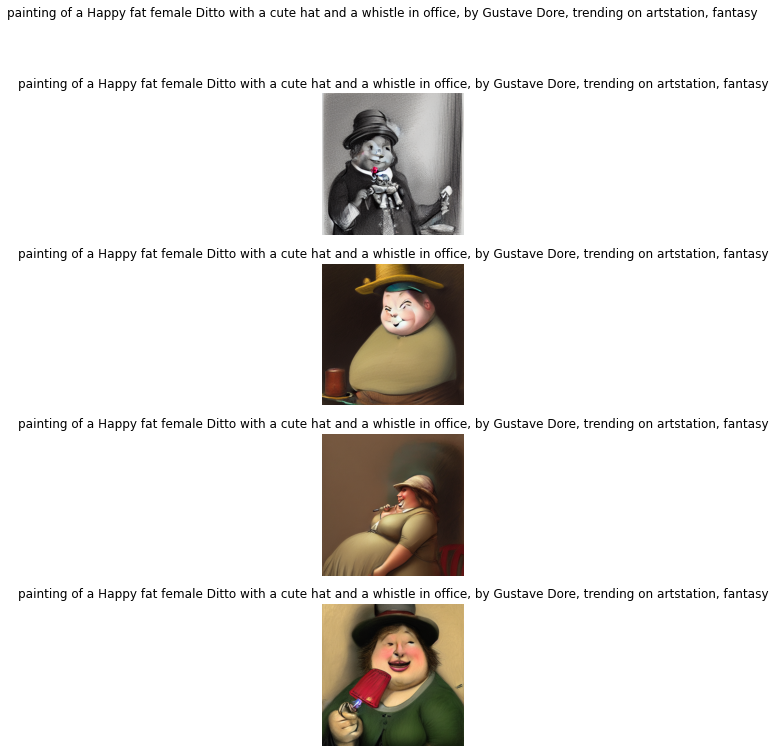

In [ ]:
make_images(initial_prompt, filepath,random_prompts=False, max_length=50, num_inference_steps =10)

In [ ]:
stories = make_story(initial_prompt,max_length=50)
stories

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Palace of Cthulhu underwater and all that?" "Well, I\'m just going to say that you really had no idea how awesome this was going to be with a little girl swimming around with your favorite shark like that." "Oh, I love you',
 "Palace of Cthulhu underwater. You can reach up to 90 feet in the air with your sword (except it's a weapon), and you have a 50% chance an attack makes it to your weapon attack range. In some battles you will have to",
 "Palace of Cthulhu underwater, the world is a barren land where only white slime exists. Once you awaken, you'll find the world's population has grown by about six millions over the course of several generations. You'll first head to Atlantis and investigate",
 "Palace of Cthulhu underwater.\n\nDangerous Mascots - I'm glad I could tell who the antagonist was more...\n\nNights Out (2015) - It looks like he's making a strong case for why he's so",
 'Palace of Cthulhu underwater, which might be why Lovecraft has told us that the ocean in Cthulhu\'s 

In [ ]:
make_prompt(initial_prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['The tree of life  with flowers, sharp focus, Highly Detailed, Cinematic Lighting, Studio Light, By Goro Fujita, mak',
 'The tree of life  ,trees  around the lake reflecting the moon.  night, underexposed, desolated wasteland, matte']

# Interesting prompts

In [ ]:
interesting_prompts = [
    'ugly pig with dirty snout, wearing Russian military uniform and military hat',
    "painting of a happy chihuahua with cute hat" ,
    'scarecrow in front of a castle, by gustave dore, by Zdzisław Beksińsk, horror gothic style, detailed hd full body face'
]

In [ ]:
print('\n'.join(stories))

Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism, which is so rare in Russia and the West that
Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism

[The Soviet writer is a writer and editor
Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism

By Vladimir V. Yushkoff

Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism and the image of an open and tolerant nation
[
Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism, and practical sense in the Soviet Union.


In [ ]:
story_pipe(initial_prompt,max_length=50, )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The tree of life \xa0is the source of life and life is from the tree of life \xa0this tree of life has eight parts. \xa0Now this means, that they are the eight elements and the four suns. \xa0So'}]

In [ ]:
prompts = make_prompt(initial_prompt,max_length=50 ,number_of_images=4)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
prompts

['Dracula Castle during thunderstorm  by David Carson',
 'Dracula Castle during thunderstorm  by Robert De Niro, trending on artstation —ar 16:9',
 'Dracula Castle during thunderstorm  in the style of a Wes Anderson film, a beautiful painting  —ar 18:14',
 'Dracula Castle during thunderstorm ']

  0%|          | 0/51 [00:00<?, ?it/s]

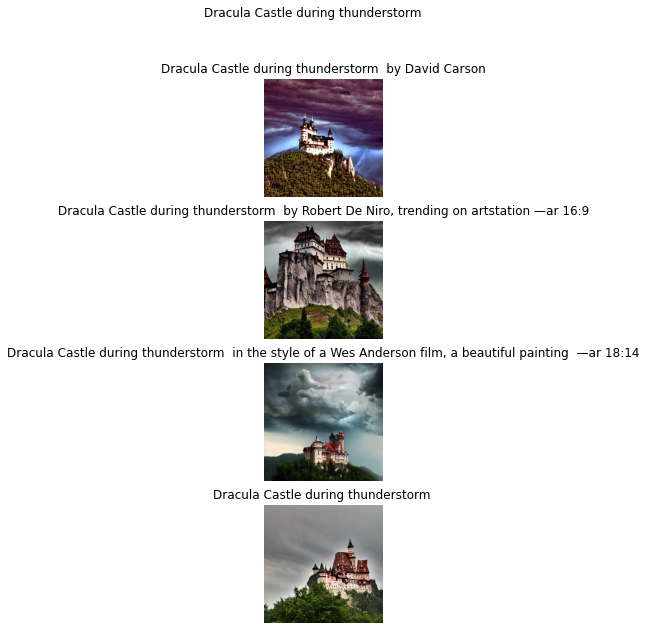

In [ ]:
make_and_save_images(prompts,initial_prompt,filepath,num_inference_steps=25)

In [ ]:
prompts =['Portrait of Lenin in front of the Kremlin inspiring soviet people, style of socialist realism']*4

In [ ]:
with autocast('cuda'):
  images = pipe(prompts,guidance_scale=7.5,num_inference_steps=50).images

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

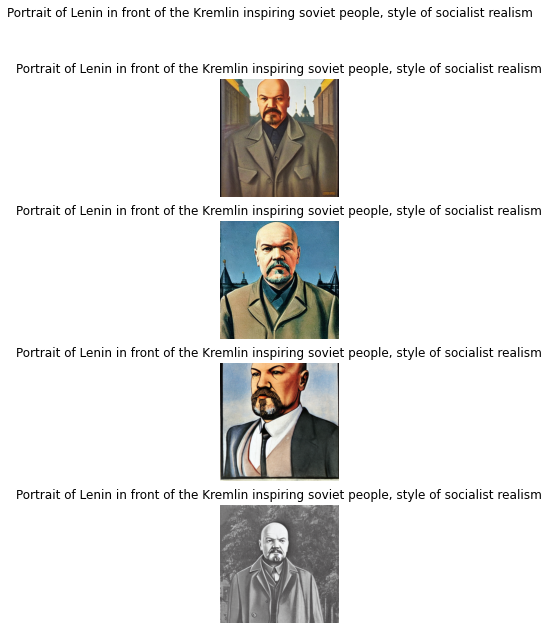

In [ ]:
make_and_save_images(prompts,initial_prompt,filepath)

In [ ]:
def metadata_plot(images, filepath, prompt,initial_prompt,stories):
    with plt.xkcd():
      fig, axs = plt.subplots(len(images),figsize=(10, 10))
      axs = axs.flatten()
      fig.patch.set_facecolor('white')
      for img, ax, txt in zip(images, axs,prompt):
          ax.imshow(img,aspect='equal')
          ax.set_axis_off()
          toptext= txt.split()[:10]
          savename = ' '.join(toptext)
          ax.set_title(txt,wrap=True)
  #         fig.suptitle(f'Total emissions from the generated images: {round(co2_emissions*1000,3)} g of CO2',
  #                      weight='bold')
      #plt.show();
      fig.add_subplot(444)
      paragraph = '\n'.join(stories)
      fig.text(0.5,.5 ,s=paragraph,wrap=True)
      fig.suptitle(initial_prompt)
      

    #plt.savefig(f'{filepath + initial_prompt} metadata.png')

In [ ]:
stories= make_story(initial_prompt=initial_prompt,max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
stories

['A dragon fighting beautiful hobbit in the forest for its feast\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLance\n\n\n\n\n\n\n\n\n\n\n\n\nLance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDal\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 "A dragon fighting beautiful hobbit in the forest, and his companions are also extremely powerful. Afterward, they try to fight in an open field so they can do the trick, but it's always hard, so the dragons become enraged. But the dragons are also really well trained, though I've never felt that anyone is doing this. In the video below, the dragon tries to fight his friend using his powers to move his foe, until he realizes that he may just need to do something to avoid losing.",
 "A dragon fighting beautiful hobbit in the forest. (Photo: Brian Young)Buy Photo\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThe Hobbits have been rescued while

In [ ]:
initial_prompt= 'Once upon a time in a forest '

In [ ]:
make_story(initial_prompt, number_of_stories=1,do_sample=True)

['Once upon a time in a forest  there was a man who was a man of great\nfortune. He was a man of great wealth, and he was a man of great\nfortune. He was a man of great wealth, and he was']

In [ ]:
    with autocast('cuda'):
        images = pipe(initial_prompt,guidance_scale=7.5,num_inference_steps=12).images

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
images

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FA268A18ED0>]

In [ ]:
def make_image(initial_prompt, num_inference_steps=12, **kwargs):
  with autocast('cuda'):
        images = pipe(initial_prompt,guidance_scale=7.5, num_inference_steps=num_inference_steps).images
  return images[0]

  0%|          | 0/7 [00:00<?, ?it/s]

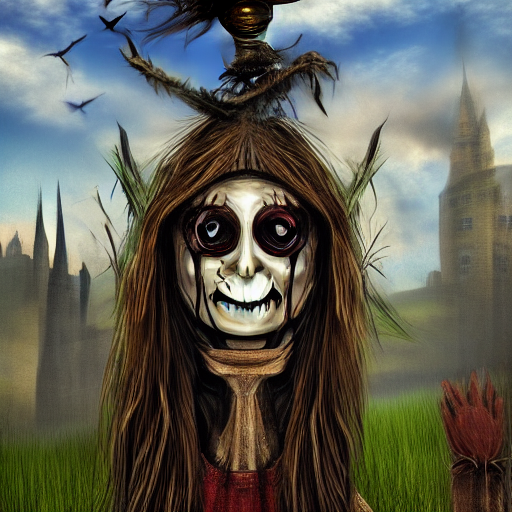

In [ ]:
make_image(initial_prompt,num_inference_steps=7)